# EXTRACAO

In [2]:
comando="""
with tc_2 as (select tc.id,tc.status
			from tb_conscientizacao tc
			group by tc.id,tc.status) 
SELECT 
	datas.id_data,
	tap."Presença de Criadouros" as area_presenca_criadouros,
	tap."Água Parada em Terrenos Baldios" as area_agua_parada_tereno_baldio,
	tap."Presença de Piscinas sem Manutenção" as pres_piscina_s_manut,
	tap."Presença de Recipientes sem Tampas" as pres_recipiente_s_tampa,
	tcd."Casos de dengue" casos_dengue,
	tcc."Precipitação" as precipitacao,
	tcc."Umidade" as umidade,
	tcc."Temperatura" as temperatura,
	tfh."Falta de Coleta de Lixo" as  falta_coleta_lixo,
	tfh."Áreas com Acúmulo de Entulhos" as area_acumulo_entulho,
	tfh."Falta de Controle de Pragas" as falta_controle,
	tfh."Taxa de Tratamento de Esgoto" as taxa_tratamento_esgoto,
	tf."conscientização da população" as conscientiza_pop,
	tf."condições de moradia precárias" as conicao_moradia_precaria,
	tf."falta de acesso a serviços de saúde" as falta_acesso_servico_saude,
	tf."migração de pessoas de áreas endêmicas" as migracao_pess_area_endemica,
	tf."transporte de mercadorias em áreas urbanas" as transp_mercadoria_area_urbana,
	tf.outros ,
	tf."presença do mosquito" as presenca_mosquito ,
	tc_2.id,
	tc_2.status as status_conscientiza
FROM (
    SELECT date(generate_series('1987-01-01'::date, '2023-12-31'::date, '1 day')) AS id_data
) AS datas
LEFT JOIN tb_agua_parada tap ON datas.id_data =tap."Date"::date 
LEFT JOIN tb_casos_dengue tcd ON datas.id_data = tcd."Date" ::date
left join tb_condicoes_climaticas tcc on datas.id_data = tcc."Date" ::date
LEFT JOIN tb_falta_higiene tfh on datas.id_data = tfh."Date" ::date
LEFT JOIN tb_fato tf  on datas.id_data = tf."Date"::date
left join tc_2 on tf."conscientização da população" =tc_2.id 

 """


In [3]:

def consultar(comando):


    class conectar():

        def __init__(self) -> None:
            import pyodbc
            self.pyodbc=pyodbc

            import pandas
            self.pandas=pandas

        def conectar(self):
            # Estabeleça a conexão com o banco de dados
            self.conn = self.pyodbc.connect(
                'DRIVER={PostgreSQL Unicode};'
                'DATABASE=base_previsao_casos_dengue;'
                'UID=competidor;'
                'PWD=competidor;'
                'SERVER=34.135.161.3;'
                'PORT=5432;'
            )
            self.cursor = self.conn.cursor()
            print('-conectado')

        def executar(self,comando):
            self.cursor.execute(comando)
            results = self.cursor.fetchall()
            colunas=[i[0] for i in self.cursor.description]
            results=[list(i) for i in results]

            results=self.pandas.DataFrame(results,columns=colunas)
            
            return results
            

        def desconectar(self):
            self.conn.close()
            print('-desconectado')

    acesso=conectar()
    acesso.conectar()
    resposta=acesso.executar(comando)
    acesso.desconectar()

    return resposta



In [4]:

resposta=consultar(comando)

-conectado
-desconectado


In [5]:
resposta.to_csv('dados.csv',decimal=',',sep=';',index=False)

# LIMPAR DADOS

In [6]:
#importar libs 
import pandas
import numpy

In [7]:
#ler dados
dt_dados_backup=pandas.read_csv('dados.csv',sep=';',decimal=',')

In [8]:
#backup dos dados
dt_dados=dt_dados_backup.copy()

In [9]:
#trocar valores indesejados por nan
dt_dados[dt_dados.isin(['indisponivel',''])]=numpy.nan

In [10]:
#tratar colunas float
colunas_float=['temperatura', 'falta_coleta_lixo', 'falta_controle', 'area_agua_parada_tereno_baldio',
                'taxa_tratamento_esgoto', 'area_acumulo_entulho', 'falta_acesso_servico_saude', 'outros', 
                'conicao_moradia_precaria', 'umidade', 'transp_mercadoria_area_urbana',
                   'precipitacao', 'area_presenca_criadouros', 'migracao_pess_area_endemica']

for coluna in colunas_float:
    #transformar em float
    dt_dados[coluna]=dt_dados[coluna].map(lambda x:float(str(x).replace(',','.')))
    #substituir pela média dos valores
    dt_dados[coluna]=dt_dados[coluna].astype(float).fillna(dt_dados[coluna].mean())


In [11]:
#tratar colunas inteiras
df_col_int=['pres_piscina_s_manut','pres_recipiente_s_tampa','presenca_mosquito']

for coluna in df_col_int:
    #transformar em int
    dt_dados.loc[dt_dados[coluna].isna()==False,coluna]=dt_dados.loc[dt_dados[coluna].isna()==False,coluna].map(lambda x:int(x))
    #substituir pela média dos valores
    dt_dados[coluna]=dt_dados[coluna].fillna(dt_dados[coluna].mean()).astype(int)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_7496\338031711.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dt_dados[coluna]=dt_dados[coluna].fillna(dt_dados[coluna].mean()).astype(int)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_7496\338031711.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dt_dados[coluna]=dt_dados[coluna].fillna(dt_dados[coluna].mean()).astype(int)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_7496\338031711.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fu

In [12]:
#criar index como datetime
dt_dados['id_data']=pandas.to_datetime(dt_dados['id_data'])
dt_dados.set_index('id_data',inplace=True)

# PROPOSTA - CRIACAO DE PARAMETRO

coluna 'chuva_XDias', é uma coluna que apura quantos "X" dias antes do dia referencia temos chuva com "Y" de precipitacao

## parametro de precipitacao

In [13]:
#indicador chuva_XDias - teste de precipitacao
df_teste_precipitar=dt_dados.copy()
teste_precipitar=[]
for i_precipitar in range(10,200):
    dias_precipitacao_maior_que_zero = df_teste_precipitar['precipitacao'].rolling(window=9).apply(lambda x: (x > i_precipitar).sum(), raw=True)
    df_teste_precipitar['chuva_XDias']=dias_precipitacao_maior_que_zero
    correlacao=df_teste_precipitar[['casos_dengue','chuva_XDias']].corr().iloc[0,1]
    teste_precipitar.append([i_precipitar,correlacao])

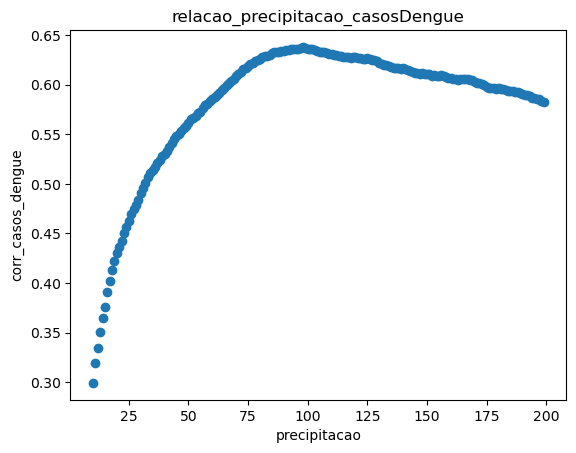

melhor valor


,precipitacao,correlacao
88,98,0.6382


In [14]:
import matplotlib.pyplot as plt
dados=teste_precipitar
# Dados das variáveis
x=[i[0] for i in dados]
y=[i[1] for i in dados]
plt.scatter(x, y)
plt.xlabel('precipitacao')
plt.ylabel('corr_casos_dengue')
plt.title('relacao_precipitacao_casosDengue')
plt.show()

tabela=pandas.DataFrame(teste_precipitar,columns=['precipitacao','correlacao'])
tabela=tabela[tabela['correlacao']==tabela['correlacao'].max()]

print('melhor valor')
display(tabela)

## parametro dias

In [15]:
#indicador chuva_XDias - teste de dias
df_teste_precipitar=dt_dados.copy()
teste_dias=[]
for i_dia in range(0,35):
    dias_precipitacao_maior_que_zero = df_teste_precipitar['precipitacao'].rolling(window=i_dia).apply(lambda x: (x > 97).sum(), raw=True)
    df_teste_precipitar['chuva_XDias']=dias_precipitacao_maior_que_zero
    correlacao=df_teste_precipitar[['casos_dengue','chuva_XDias']].corr().iloc[0,1]
    teste_dias.append([i_dia,correlacao])

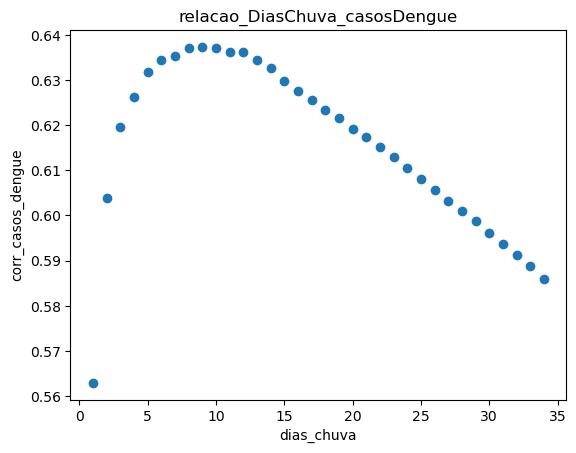

melhor valor


,dias_chuva,correlacao
9,9,0.637328


In [16]:
import matplotlib.pyplot as plt
dados=teste_dias
# Dados das variáveis
x=[i[0] for i in dados]
y=[i[1] for i in dados]
plt.scatter(x, y)
plt.xlabel('dias_chuva')
plt.ylabel('corr_casos_dengue')
plt.title('relacao_DiasChuva_casosDengue')
plt.show()

tabela=pandas.DataFrame(teste_dias,columns=['dias_chuva','correlacao'])
tabela=tabela[tabela['correlacao']==tabela['correlacao'].max()]

print('melhor valor')
display(tabela)

# CRIACAO DA COLUNA COM PARAMETROS AJUSTADOS

In [17]:
#coluna chuva_XD - 
dias_precipitacao_maior_que_zero = dt_dados['precipitacao'].rolling(window=9).apply(lambda x: (x > 98).sum(), raw=True)
dt_dados['chuva_XDias']=dias_precipitacao_maior_que_zero

## comparar correlacao da nova variavel

In [18]:
#comparar correlação
dt_dados[['casos_dengue','temperatura','umidade','precipitacao','chuva_XDias']].corr()

,casos_dengue,temperatura,umidade,precipitacao,chuva_XDias
casos_dengue,1.000000,0.435860,0.443209,0.558106,0.638200
temperatura,0.435860,1.000000,0.484303,0.533262,0.583222
umidade,0.443209,0.484303,1.000000,0.562347,0.614553
precipitacao,0.558106,0.533262,0.562347,1.000000,0.791368
chuva_XDias,0.638200,0.583222,0.614553,0.791368,1.000000


In [19]:
#visualicação interativa

#import dtale
#dtale.show(dt_dados,open_browser=True)